<a href="https://colab.research.google.com/github/mhtabkrklt/ML_Tasks/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [6]:
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)
print(f"Размер: {df.shape}")
df

Размер: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


age: Возраст основного бенефициара.

sex: Пол страхователя (female, male).

bmi: Индекс массы тела (ИМТ). Отношение веса к росту (кг/м
2
 ). Идеальный диапазон: 18.5–24.9.

children: Количество детей/иждивенцев, покрываемых страховкой.

smoker: Статус курения.

region: Район проживания в США (северо-восток, юго-восток, юго-запад, северо-запад).

charges: Медицинские расходы (Целевая переменная).

Цель: предсказать индивидуальные медицинские расходы (стоимость страховки).

In [7]:
target = 'charges'
X = df.drop(columns=[target])
y = np.log1p(df[target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

X_tr = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_test)


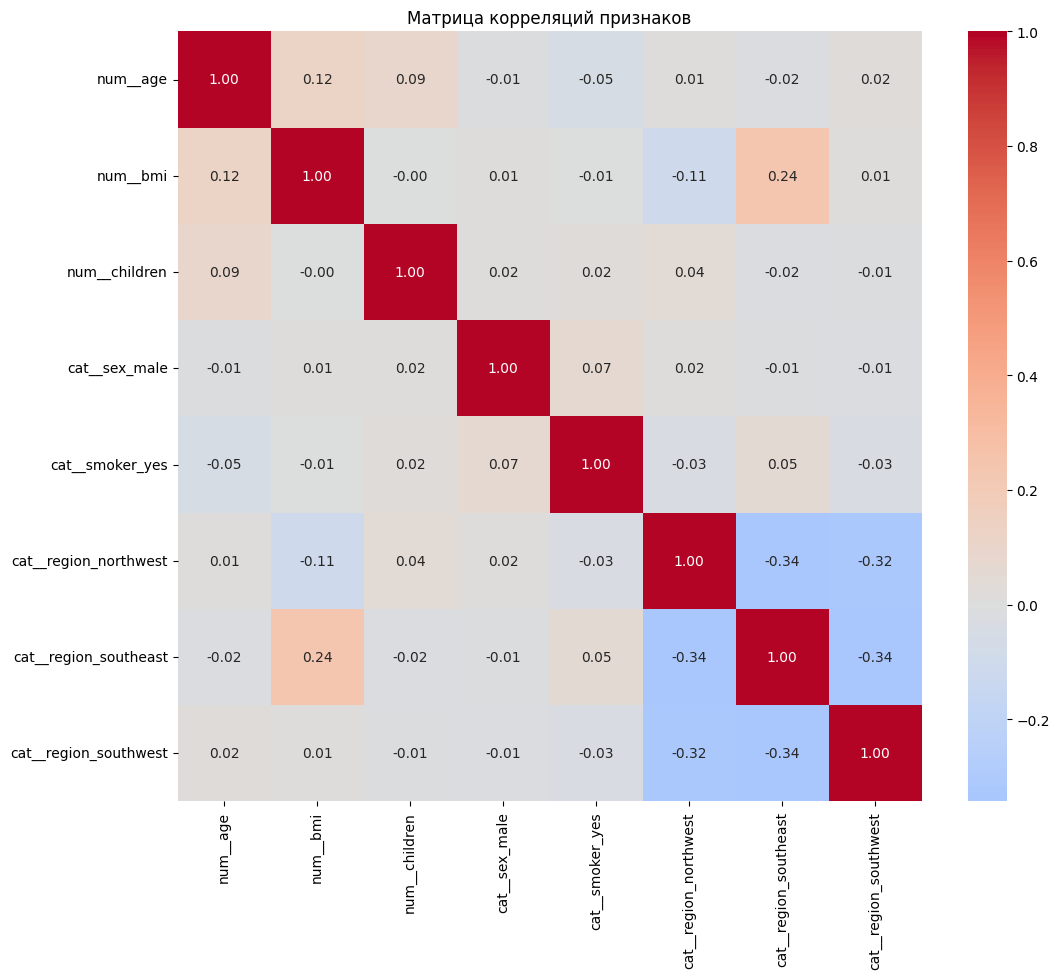


Результаты анализа VIF:
                 feature       VIF
3          cat__sex_male  1.674540
6  cat__region_southeast  1.321224
5  cat__region_northwest  1.235177
4        cat__smoker_yes  1.225159
7  cat__region_southwest  1.217099
1               num__bmi  1.074888
0               num__age  1.027936
2          num__children  1.010691


In [8]:
feature_names = preprocessor.get_feature_names_out()

X_tr_df = pd.DataFrame(X_tr, columns=feature_names)

plt.figure(figsize=(12, 10))
sns.heatmap(X_tr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Матрица корреляций признаков")
plt.show()

#  VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["feature"] = X_tr_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_tr_df.values, i)
                          for i in range(len(X_tr_df.columns))]
print("\nРезультаты анализа VIF:")
print(vif_data.sort_values(by="VIF", ascending=False))

Проблемы нет: Все значения VIF находятся в диапазоне 1.0–1.7, что значительно ниже критического порога (обычно 5 или 10).

In [9]:
def evaluate_model(model, X_val, y_val_log, model_name):

    y_pred_log = model.predict(X_val)

    y_val_real = np.expm1(y_val_log)
    y_pred_real = np.expm1(y_pred_log)

    r2    = r2_score(y_val_real, y_pred_real)
    mae   = mean_absolute_error(y_val_real, y_pred_real)
    mse   = mean_squared_error(y_val_real, y_pred_real)
    rmse  = np.sqrt(mse)
    mape  = mean_absolute_percentage_error(y_val_real, y_pred_real)
    medae = median_absolute_error(y_val_real, y_pred_real)

    print(f"\n {model_name} ")
    print(f"R2:    {r2:.4f}")
    print(f"MAE:   {mae:.2f}")
    print(f"RMSE:  {rmse:.2f}")
    print(f"MAPE:  {mape:.4f}")
    print(f"MedAE: {medae:.2f}")

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_val_real, y=y_pred_real, alpha=0.6)
    plt.plot([y_val_real.min(), y_val_real.max()], [y_val_real.min(), y_val_real.max()], 'r--')
    plt.xlabel("Факт")
    plt.ylabel("Прогноз")
    plt.title(f"{model_name}: Fact vs Predict")
    plt.show()


 Linear Regression 
R2:    0.6377
MAE:   3856.30
RMSE:  7499.80
MAPE:  0.2801
MedAE: 1058.21


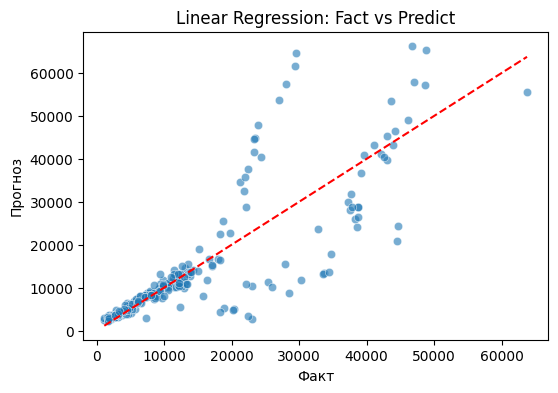

In [10]:
model = LinearRegression()
model.fit(X_tr, y_train)
evaluate_model(model, X_val, y_test, "Linear Regression")


 KNN Regressor 
R2:    0.5642
MAE:   4404.06
RMSE:  8225.11
MAPE:  0.3140
MedAE: 1628.07


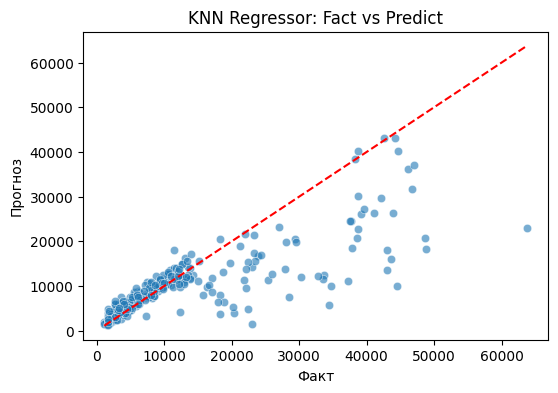

In [11]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_tr, y_train)
evaluate_model(model, X_val, y_test, "KNN Regressor")


 Decision Tree 
R2:    0.8468
MAE:   2461.24
RMSE:  4876.23
MAPE:  0.2184
MedAE: 1060.16


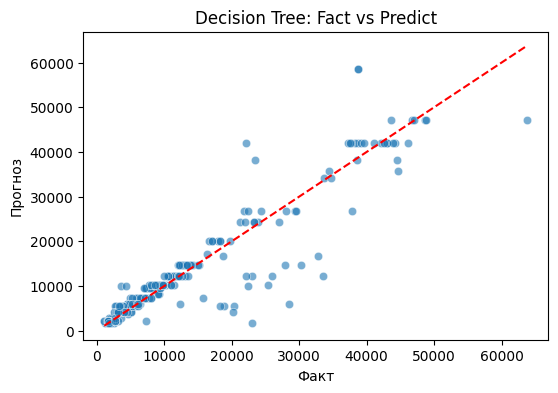

In [12]:
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_tr, y_train)
evaluate_model(model, X_val, y_test, "Decision Tree")


 SVR 
R2:    0.8276
MAE:   2260.34
RMSE:  5173.78
MAPE:  0.1289
MedAE: 673.93


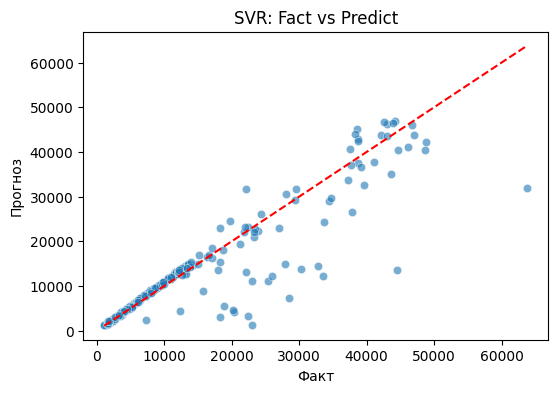

In [13]:
model = SVR(C=1.0, epsilon=0.1)
model.fit(X_tr, y_train)
evaluate_model(model, X_val, y_test, "SVR")

По итогам обучения четырех моделей я сравнил их метрики. Вот что получилось:

SVR (Метод опорных векторов) оказался лучшей моделью. У него самая низкая средняя ошибка (MAE ≈ 2260), то есть в среднем прогноз отклоняется от реальной стоимости страховки меньше всего. Также у него минимальная ошибка в процентах (MAPE ~13%).

Дерево решений заняло второе место. Хотя коэффициент детерминации (R
2
 ) у него даже выше, чем у SVR, реальные ошибки в долларах (RMSE и MAE) все же больше.

Линейная регрессия и KNN показали слабые результаты (R
2
  в районе 0.56–0.64). Это говорит о том, что зависимость стоимости страховки от признаков не является прямой, и простые модели с ней не справляются.